# MOT17 Tracking Notebook (Fixed Version)

This notebook demonstrates an updated tracking workflow on the MOT17 dataset using YOLOv8. It now offers two modes of initialization:

1. **Detection-Only Initialization:** The tracker is initialized by running the detector on all frames (including frame 1).
2. **GT Initialization with Detection Update:** The tracker is initialized from the ground-truth for frame 1 and then updated with detections. In this mode, you can merge the GT data with the detections on the first frame so that later detections can be correctly associated with the GT-initialized tracks.

Adjust the `use_detection_first_frame` flag in the `main()` function to select your preferred mode.

Be sure to update the paths for your MOT17 dataset and adjust parameters (such as IOU threshold, confidence threshold, and max age) as needed.

In [3]:
import os
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
from ultralytics import YOLO
import matplotlib.pyplot as plt

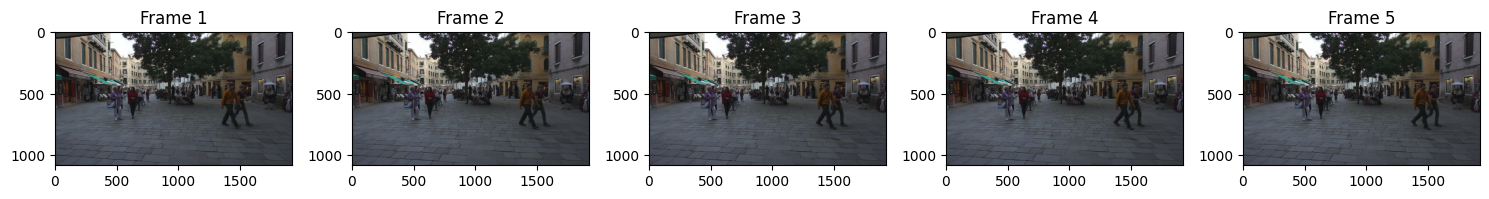

Processing: 50/600 frames
Processing: 100/600 frames
Processing: 150/600 frames
Processing: 200/600 frames
Processing: 250/600 frames
Processing: 300/600 frames
Processing: 350/600 frames
Processing: 400/600 frames
Processing: 450/600 frames
Processing: 500/600 frames
Processing: 550/600 frames
Processing: 600/600 frames
Video saved as result_video.avi


In [4]:
# --------------------------
# Track Class Definition
# --------------------------
class Track:
    def __init__(self, track_id, bbox):
        """
        bbox: [x1, y1, x2, y2]
        """
        self.id = track_id
        self.bbox = bbox
        self.age = 0

    def update(self, new_bbox):
        self.bbox = new_bbox
        self.age = 0

    def predict(self):
        self.age += 1

# --------------------------
# Visualization Function
# --------------------------
def visualize_frames(frames_dir, num_frames=5):
    """Display the first few frames from the MOT17 image directory."""
    plt.figure(figsize=(15, 5))
    for i in range(num_frames):
        # Assuming MOT17 frames use zero-padded names like '000001.jpg'
        filename = f"{i+1:06d}.jpg"
        path = os.path.join(frames_dir, filename)
        if os.path.exists(path):
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_frames, i+1)
            plt.imshow(img)
            plt.title(f'Frame {i+1}')
    plt.tight_layout()
    plt.show()

# --------------------------
# Ground Truth Loading Function
# --------------------------
def load_tracks_from_gt(gt_file, init_frame=1):
    """
    Load initial tracks from the MOT17 ground truth file.
    MOT17 GT format (CSV): frame, id, bb_left, bb_top, bb_width, bb_height, ...
    Only tracks from the specified init_frame are loaded.
    """
    tracks = []
    with open(gt_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame_num = int(parts[0])
            if frame_num != init_frame:
                continue
            track_id = int(parts[1])
            x = int(float(parts[2]))
            y = int(float(parts[3]))
            w = int(float(parts[4]))
            h = int(float(parts[5]))
            tracks.append(Track(track_id, [x, y, x+w, y+h]))
    return tracks

# --------------------------
# List Frames Function
# --------------------------
def list_frames(frames_dir):
    """Return a sorted list of frame filenames (assumes names are numeric with .jpg extension)."""
    frame_files = [f for f in os.listdir(frames_dir) if f.endswith('.jpg')]
    frame_files = sorted(frame_files, key=lambda x: int(x.split('.')[0]))
    return frame_files

# --------------------------
# YOLO Detection Function
# --------------------------
def run_detection_on_frame(model, frame, class_id, conf_thresh=0.5):
    """
    Run YOLO detection on a frame and return detection boxes for the target class.
    Boxes are formatted as [x1, y1, x2, y2].
    """
    results = model.predict(frame, conf=conf_thresh, classes=[class_id], verbose=False)
    detections = []
    if results and results[0].boxes is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        # You can also check confidence values if needed
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            detections.append([x1, y1, x2, y2])
    return detections

# --------------------------
# Intersection-over-Union Function
# --------------------------
def compute_iou(box_a, box_b):
    """Compute the Intersection over Union (IoU) between two bounding boxes."""
    xA = max(box_a[0], box_b[0])
    yA = max(box_a[1], box_b[1])
    xB = min(box_a[2], box_b[2])
    yB = min(box_a[3], box_b[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    boxBArea = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    unionArea = boxAArea + boxBArea - interArea
    iou = interArea / unionArea if unionArea > 0 else 0
    return iou

# --------------------------
# Track Update Function
# --------------------------
def update_tracks(tracks, detections, iou_threshold):
    """
    Given current tracks and new detections, update existing tracks using the Hungarian algorithm.
    New tracks are created for unmatched detections.
    """
    # If no tracks exist, initialize one for each detection.
    if not tracks:
        for d in detections:
            new_id = 1  
            tracks.append(Track(new_id, d))
        return tracks

    # Build the IoU matrix
    iou_matrix = np.zeros((len(tracks), len(detections)))
    for t, track in enumerate(tracks):
        for d, det in enumerate(detections):
            iou_matrix[t, d] = compute_iou(track.bbox, det)

    # Perform Hungarian assignment using negative IoU as cost
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    matched_indices = set()
    for t, d in zip(row_ind, col_ind):
        if iou_matrix[t, d] >= iou_threshold:
            tracks[t].update(detections[d])
            matched_indices.add(d)

    # For any detection that did not match any track, create a new track
    for d in range(len(detections)):
        if d not in matched_indices:
            new_id = max([t.id for t in tracks], default=0) + 1
            tracks.append(Track(new_id, detections[d]))

    return tracks

# --------------------------
# Track Aging Function
# --------------------------
def age_tracks(tracks, max_age):
    """Increase each track's age and remove any that exceed the maximum age."""
    for track in tracks:
        track.predict()
    tracks = [t for t in tracks if t.age <= max_age]
    return tracks

# --------------------------
# Frame Processing Function
# --------------------------
def process_frames(frames_dir, tracks, model, class_id, output_file, iou_threshold, max_age,
                   conf_thresh=0.5, use_detection_first_frame=True):
    """
    Process frames for detection and tracking, writing results to a file.
    If use_detection_first_frame is True, run detection on every frame including the first frame;
    otherwise, use ground-truth initialization for frame 1 and run detection starting at frame 2.
    Each result entry is: frame track_id x y width height.
    """
    frame_files = list_frames(frames_dir)
    with open(output_file, 'w') as results_file:
        for frame_num, frame_file in enumerate(frame_files, start=1):
            img_path = os.path.join(frames_dir, frame_file)
            frame = cv2.imread(img_path)
            if frame is None:
                continue

            # Option: if not using detection for the first frame, then use GT (tracks are already initialized) 
            if frame_num == 1 and not use_detection_first_frame:
                detections = []  # No detection on the first frame
            else:
                detections = run_detection_on_frame(model, frame, class_id, conf_thresh)

                # (Optional) On frame 1, if using GT initialization, you might want to merge detections with GT tracks
                # For simplicity, here we use detection exclusively if use_detection_first_frame=True

            tracks = update_tracks(tracks, detections, iou_threshold)
            tracks = age_tracks(tracks, max_age)

            # Write each track's info: frame, track id, x, y, width, height
            for track in tracks:
                x1, y1, x2, y2 = track.bbox
                results_file.write(f"{frame_num} {track.id} {x1} {y1} {x2-x1} {y2-y1}\n")

            if frame_num % 50 == 0:
                print(f"Processing: {frame_num}/{len(frame_files)} frames")
    return frame_files

# --------------------------
# Tracking Results Loader Function
# --------------------------
def load_tracking_results(results_file):
    """
    Load the tracking results from the file and return a dictionary keyed by frame.
    Each entry is a list of tuples: (track_id, x, y, width, height).
    """
    tracking_results = {}
    with open(results_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            frame_id = int(parts[0])
            track_id = int(parts[1])
            x = int(parts[2])
            y = int(parts[3])
            w = int(parts[4])
            h = int(parts[5])
            tracking_results.setdefault(frame_id, []).append((track_id, x, y, w, h))
    return tracking_results

# --------------------------
# Video Creation Function
# --------------------------
def create_output_video(frames_dir, frame_files, tracking_results, output_video, fps):
    """
    Create a video with overlaid tracking results.
    Draw the bounding boxes and track IDs on each frame and write the result to a video file.
    """
    first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
    height, width, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for idx, frame_file in enumerate(frame_files, start=1):
        frame = cv2.imread(os.path.join(frames_dir, frame_file))
        if idx in tracking_results:
            for (track_id, x, y, w, h) in tracking_results[idx]:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, f"ID {track_id}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        video_writer.write(frame)

    video_writer.release()
    print("Video saved as", output_video)

# --------------------------
# Main Function
# --------------------------
def main():
    # Configuration for MOT17 Dataset (update these paths as needed)
    FRAMES_DIR = './TP3_data/MOT17/MOT17/train/MOT17-02-FRCNN/img1'     # Adjust to your MOT17 sequence path
    INIT_FILE = './TP3_data/MOT17/MOT17/train/MOT17-02-FRCNN/gt/gt.txt'   # Ground-truth file
    OUTPUT_FILE = 'results.txt'
    IOU_THRESHOLD = 0.6
    MAX_AGE = 5
    CLASS_NAME = 'person'                      # MOT17 mainly focuses on pedestrians
    FPS = 20
    OUTPUT_VIDEO = 'result_video.avi'

    # Toggle the mode: set to True to run detection on ALL frames (recommended for continuous tracking).
    # Set to False if you want to initialize with GT on frame 1 and run detection on frames > 1
    use_detection_first_frame = True

    # Visualize initial frames
    visualize_frames(FRAMES_DIR, num_frames=5)

    # Load YOLO model (ensure this model detects persons)
    model = YOLO('yolov8n.pt')
    class_id = None
    for k, v in model.names.items():
        if v.lower() == CLASS_NAME:
            class_id = k
            break
    if class_id is None:
        raise ValueError(f"Class '{CLASS_NAME}' not found in the model")

    # Option: If not using detection on frame 1, initialize tracks from GT
    if not use_detection_first_frame:
        tracks = load_tracks_from_gt(INIT_FILE, init_frame=1)
    else:
        tracks = []  # Start with empty tracks; detection will initialize them from frame 1

    # Process frames: detection, tracking, and writing results.
    frame_files = process_frames(FRAMES_DIR, tracks, model, class_id, OUTPUT_FILE,
                                  IOU_THRESHOLD, MAX_AGE, conf_thresh=0.5,
                                  use_detection_first_frame=use_detection_first_frame)

    # Load tracking results
    tracking_results = load_tracking_results(OUTPUT_FILE)

    # Create the output video with tracking overlays
    create_output_video(FRAMES_DIR, frame_files, tracking_results, OUTPUT_VIDEO, FPS)

if __name__ == '__main__':
    main()